<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


<!-- ![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif) -->


Several examples of an unsuccessful landing are shown here:


<!-- ![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif) -->


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing  # Preprocessing allows us to standarsize our data
from sklearn.model_selection import train_test_split  # Allows us to split our data into training and testing data
from sklearn.model_selection import GridSearchCV  # Allows us to test parameters of classification algorithms and find the best one
from sklearn.linear_model import LogisticRegression  # Logistic Regression classification algorithm
from sklearn.svm import SVC  # Support Vector Machine classification algorithm
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classification algorithm
from sklearn.neighbors import KNeighborsClassifier  # K Nearest Neighbors classification algorithm

Array = np.ndarray

This function is to plot the confusion matrix.


In [43]:
def plot_confusion_matrix(y:Array, y_predict:Array, normalize:str=None) -> None:
    """Plots a confusion matrix for the given data."""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict, normalize=normalize)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['failure', 'landed'])
    ax.yaxis.set_ticklabels(['failure', 'landed'])

## Load the dataframe


Load the data


In [3]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
# If you were unable to complete the previous lab correctly you can uncomment and load this csv:
# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')
print(data.shape)
display(data.head(3))

(90, 18)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0


In [4]:
# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
# If you were unable to complete the previous lab correctly you can uncomment and load this csv:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')
display(X.head(3))

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [5]:
print(*map(repr, X.columns), sep = ", ")

'FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount', 'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS', 'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO', 'Orbit_SO', 'Orbit_SSO', 'Orbit_VLEO', 'LaunchSite_CCAFS SLC 40', 'LaunchSite_KSC LC 39A', 'LaunchSite_VAFB SLC 4E', 'LandingPad_5e9e3032383ecb267a34e7c7', 'LandingPad_5e9e3032383ecb554034e7c9', 'LandingPad_5e9e3032383ecb6bb234e7ca', 'LandingPad_5e9e3032383ecb761634e7cb', 'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005', 'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005', 'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010', 'Serial_B1011', 'Serial_B1012', 'Serial_B1013', 'Serial_B1015', 'Serial_B1016', 'Serial_B1017', 'Serial_B1018', 'Serial_B1019', 'Serial_B1020', 'Serial_B1021', 'Serial_B1022', 'Serial_B1023', 'Serial_B1025', 'Serial_B1026', 'Serial_B1028', 'Serial_B1029', 'Serial_B1030', 'Serial_B1031', 'Serial_B1032', 'Serial_B1034', 'Serial_B1035', 'Serial_B1036', 'Seri

## TASK 1 &ndash; Convert Column `'Class'` to a Numpy Array


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [6]:
Y = data['Class'].to_numpy()
print(Y.shape)

(90,)


## TASK 2 &ndash; Apply Standard Scaler


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [7]:
transform = preprocessing.StandardScaler()
X_old = X
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3 &ndash; Train Test Split


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [9]:
Y_test.shape

(18,)

## TASK  4 &ndash; Logistic Regression

Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [10]:
parameters = {'C': [0.01, 0.1, 1.0], 'penalty': ['l2'], 'solver': ['lbfgs']}  # l1=lasso, l2=ridge
lr = LogisticRegression()

logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1.0], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [11]:
print("tuned hpyerparameters: (best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters: (best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## `TASK  5 -- Score for Logistic Regression`

Calculate the accuracy on the test data using the method <code>score</code>:


In [12]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Lets look at the confusion matrix:


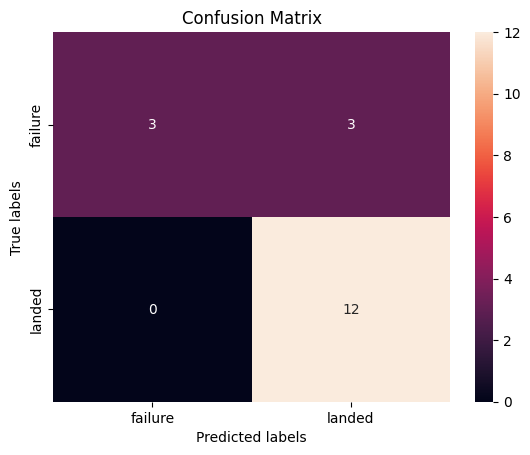

In [13]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK 6 &ndash; SVC


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [14]:
parameters = {
    'kernel': ('linear', 'rbf','poly','rbf', 'sigmoid'),
    'C': np.logspace(-2, 0, 5),
    'gamma': np.logspace(-2, -1, 5)
}
svm = SVC()

svm_cv = GridSearchCV(estimator=svm, param_grid=parameters, cv=10)

In [15]:
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]),
                         'gamma': array([0.01      , 0.01778279, 0.03162278, 0.05623413, 0.1       ]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [16]:
print("tuned hpyerparameters :(best parameters) ", svm_cv.best_params_)
print("accuracy :", svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
accuracy : 0.8625


## `TASK  7 -- Score for SVC`

Calculate the accuracy on the test data using the method <code>score</code>:


In [17]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


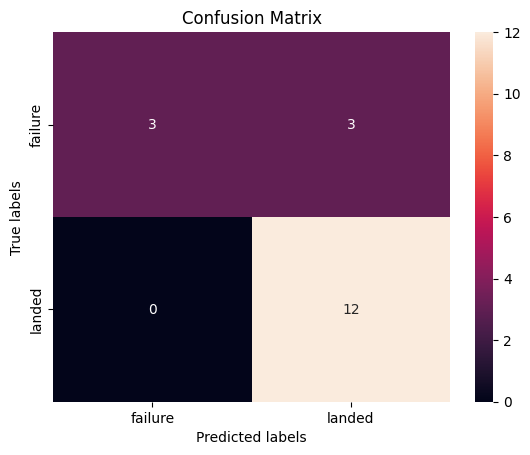

In [18]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK 8 &ndash; Decision Tree Classifier


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [19]:
parameters = {
     'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [1, 2, 3, 4],
     'max_features': [0.4, 0.5, 0.6],
     'min_samples_leaf': [1, 2],
     'min_samples_split': [7, 9, 11]
}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=10)

In [20]:
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4],
                         'max_features': [0.4, 0.5, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [7, 9, 11],
                         'splitter': ['best', 'random']})

In [21]:
print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)
print("accuracy :", tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 2, 'min_samples_split': 11, 'splitter': 'random'}
accuracy : 0.8892857142857142


## `TASK 9 -- Score for Decision Tree Classifier`


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [22]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


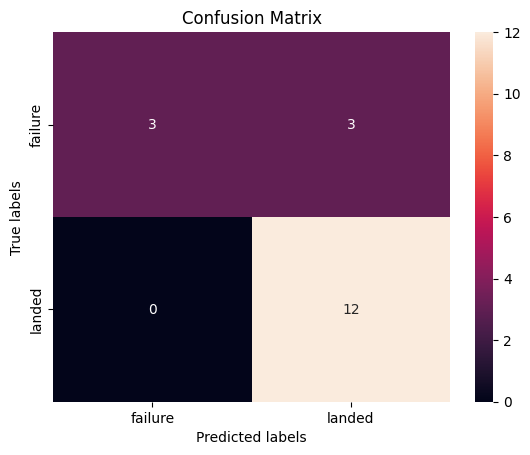

In [23]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK 10 &ndash; KNN Classifier


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [24]:
parameters = {
    'n_neighbors': list(range(3, 8)),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 1.5, 2]
}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters, cv=18)

In [25]:

knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=18, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6, 7], 'p': [1, 1.5, 2]})

In [26]:
print("tuned hpyerparameters: (best parameters) ", knn_cv.best_params_)
print("accuracy :", knn_cv.best_score_)

tuned hpyerparameters: (best parameters)  {'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 1.5}
accuracy : 0.8611111111111112


## `TASK 11 -- Score for KNN Classifier`

Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [27]:
knn_cv.score(X_test, Y_test)

0.7777777777777778

We can plot the confusion matrix


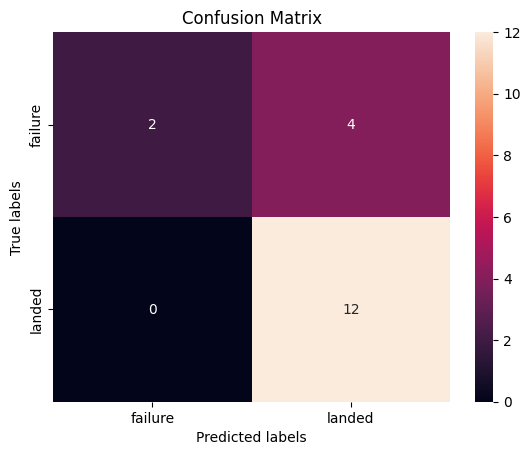

In [28]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK 12 &ndash; Compare the Models

Find the method performs best:


In [35]:
# find the method that performs best:
names = ["Logistic Regression", "SVM", "Decision Tree", "KNN"]
classifiers = [cc.best_estimator_ for cc in (logreg_cv, svm_cv, tree_cv, knn_cv)]
train_scores = [model.score(X_train, Y_train) for model in classifiers]
test_scores = [model.score(X_test, Y_test) for model in classifiers]
grid_search_scores = [model.best_score_ for model in (logreg_cv, svm_cv, tree_cv, knn_cv)]

for name, model, train_score, test_score,z in zip(names, classifiers, train_scores, test_scores, grid_search_scores):
    print(f"{model}")
    print(f"\tScores for {name}:")
    print(f"\t(grid_score = {z:.3f}, train_score = {train_score:.3f}, test_score = {test_score:.3f})\n")


LogisticRegression(C=0.01)
	Scores for Logistic Regression:
	(grid_score = 0.846, train_score = 0.875, test_score = 0.833)

SVC(C=0.01, gamma=0.01, kernel='linear')
	Scores for SVM:
	(grid_score = 0.863, train_score = 0.958, test_score = 0.833)

DecisionTreeClassifier(max_depth=3, max_features=0.4, min_samples_leaf=2,
                       min_samples_split=11, splitter='random')
	Scores for Decision Tree:
	(grid_score = 0.889, train_score = 0.861, test_score = 0.833)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, p=1.5)
	Scores for KNN:
	(grid_score = 0.861, train_score = 0.875, test_score = 0.778)



In [36]:
best_model = max(logreg_cv, svm_cv, tree_cv, knn_cv, key=lambda x: (x.score(X_test, Y_test), x.score(X_train, Y_train)))

print(best_model.best_estimator_)
print(f"Best model's train set score: {best_model.score(X_train, Y_train):.3f}")
print(f"Best model's test set score: {best_model.score(X_test, Y_test):.3f}")

SVC(C=0.01, gamma=0.01, kernel='linear')
Best model's train set score: 0.958
Best model's test set score: 0.833


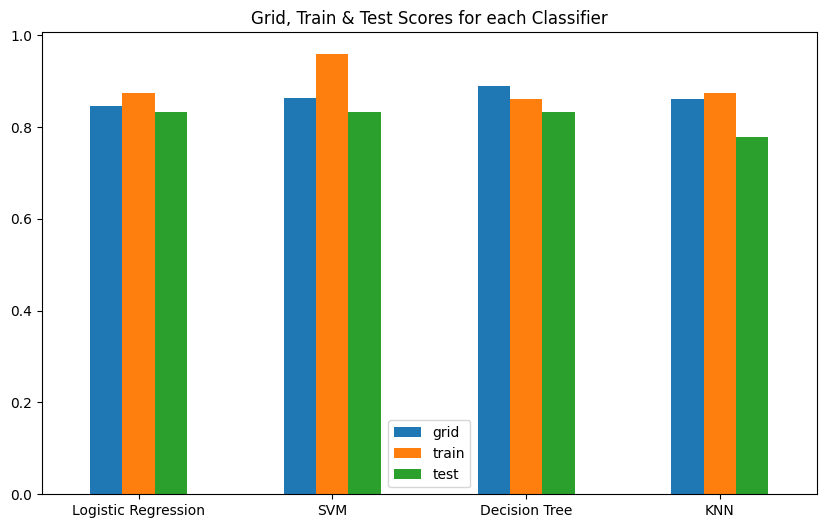

In [40]:
# Create grouped bar plot with seaborn, comparing grid, train and test scores for each classifier:

df = pd.DataFrame({
    'grid': grid_search_scores,
    'train': train_scores,
    'test': test_scores,
}, index=names)

df.plot.bar(rot=0, figsize=(10, 6), title='Grid, Train & Test Scores for each Classifier');

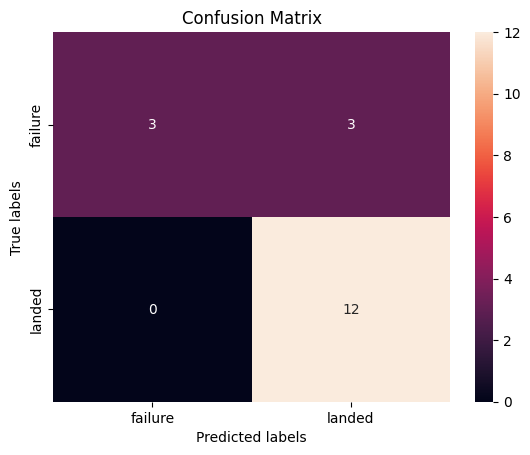

In [45]:
# Confusion matrix for the best performing svc model:

yhat = best_model.predict(X_test)

plot_confusion_matrix(Y_test, yhat, normalize=None)

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
